In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
seed_value = 42
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)  # For full reproducibility
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# --- Improved Plot Settings ---
plt.close('all')
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 12,
    'figure.dpi': 100,
    'figure.figsize': (6, 4),
    'axes.grid': True,
    'grid.alpha': 0.5,
    'lines.linewidth': 2,
    'savefig.bbox': 'tight',
    'savefig.dpi': 300
})

In [2]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.7/190.7 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import deepxde as dde
from deepxde.backend import tf
#tf.random.set_seed(seed_value)

def check_nan(tensor, name=""):
    return tf.debugging.check_numerics(tensor, message=f"{name} contains NaN or Inf")

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [4]:
def Prr(R, r):
    r_R = r
    R_2 = tf.pow(R, 2.0)
    dr_dR = dde.grad.jacobian(r, R)
    r_R_2 = tf.pow(r_R, 2.0)
    dr_dR_2 = tf.pow(dr_dR, 2.0)
    

    #term_common = dr_dR_2 * r_R_2 / R_2
    epsilon = 1e-5
    
    term_common = dr_dR_2 * r_R_2 / (R_2 + epsilon)

    term1_numerator_rr = tf.pow(4.0, 2.0/3.0) * (dr_dR_2 + r_R_2 + 4) * dr_dR * r_R_2
    term1_denumerator_rr = 6.0 * R_2 * tf.pow(term_common, 4.0/3.0)

    term2_numerator_rr = tf.pow(4.0, 2.0/3.0) * dr_dR
    term2_denumerator_rr = 2.0 *  tf.pow(term_common, 1.0/3.0) + epsilon

    term3_numerator_rr = (2.0 * tf.pow(term_common, 1.0/2.0) - 1.0) * 2.0 * dr_dR * r_R_2

    term3_denumerator_rr = tf.pow(term_common, 1.0/2.0) * R_2 + epsilon

    #Prr_final = 1500.0 * (-term1_numerator_rr / term1_denumerator_rr + term2_numerator_rr / term2_denumerator_rr) + 5000.0 * term3_numerator_rr / term3_denumerator_rr
    Prr_final = 1500.0 * term1_numerator_rr / (term1_denumerator_rr + epsilon)

    #Prr_final = check_nan(Prr_final, "Prr_final")
    
    return Prr_final


def Ptt(R, r):
    r_R = r
    R_2 = tf.pow(R, 2.0)
    dr_dR = dde.grad.jacobian(r, R, i=0, j=0)
    r_R_2 = tf.pow(r_R, 2.0)
    dr_dR_2 = tf.pow(dr_dR, 2.0)
    epsilon = 1e-5
    

    #term_common = dr_dR_2 * r_R_2 / R_2
    term_common = dr_dR_2 * r_R_2 / (R_2 + 1e-8)

    term1_numerator_tt = tf.pow(4.0, 2.0/3.0) * (dr_dR_2 + r_R_2 + 4) * dr_dR_2 * r_R
    term1_denumerator_tt = 6.0 * R * tf.pow(term_common, 4.0/3.0)

    term2_numerator_tt = tf.pow(4.0, 2.0/3.0) * r_R
    term2_denumerator_tt = 2.0 * R *  tf.pow(term_common, 1.0/3.0)

    term3_numerator_tt = (2.0 * tf.pow(term_common, 1.0/2.0) - 1.0) * 2.0 * dr_dR_2 * r_R

    term3_denumerator_tt = tf.pow(term_common, 1.0/2.0) * R
    
    #Pthetatheta = 1500.0 * (-term1_numerator_tt / term1_denumerator_tt + term2_numerator_tt / term2_denumerator_tt) + 5000.0 * term3_numerator_tt / term3_denumerator_tt

    Pthetatheta = 1500.0 * -term1_numerator_tt / (term1_denumerator_tt + epsilon)
                            
    return term_common


def pde(R, r):
    epsilon = 1e-5
    return dde.grad.jacobian(Prr(R,r), r, i=0, j=0) + Prr(R,r) / (R + epsilon) + Ptt(R,r) / (R + epsilon)
    #dy_xx = dde.grad.hessian(r, R)
    #return dy_xx - 2

def boundary_d(R, on_boundary):
    return on_boundary and dde.utils.isclose(R[0], 1e-5)

def boundary_n(R, on_boundary):
    return on_boundary and dde.utils.isclose(R[0], 1)


def func_bc_n(R, r):
    #R = tf.convert_to_tensor(R)  # Convert x to a TensorFlow tensor
    r_R = r
    R_2 = tf.pow(R, 2.0)
    dr_dR = dde.grad.jacobian(r, R, i=0, j=0)
    r_R_2 = tf.pow(r_R, 2.0)
    dr_dR_2 = tf.pow(dr_dR, 2.0)
    

    term_common = dr_dR_2 * r_R_2 / R_2
    
    # Prr
    
    term1_numerator_rr = tf.pow(4.0, 2.0/3.0) * (dr_dR_2 + r_R_2 + 4) * dr_dR * r_R_2
    term1_denumerator_rr = 6.0 * R_2 * tf.pow(term_common, 4.0/3.0)

    term2_numerator_rr = tf.pow(4.0, 2.0/3.0) * dr_dR
    term2_denumerator_rr = 2.0 *  tf.pow(term_common, 1.0/3.0)

    term3_numerator_rr = (2.0 * tf.pow(term_common, 1.0/2.0) - 1.0) * 2.0 * dr_dR * r_R_2

    term3_denumerator_rr = tf.pow(term_common, 1.0/2.0) * R_2

    Prr = 1500.0 * (-term1_numerator_rr / term1_denumerator_rr + term2_numerator_rr / term2_denumerator_rr) + 5000.0 * term3_numerator_rr / term3_denumerator_rr
    return Prr


geom = dde.geometry.Interval(1e-5, 1)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_d)
#bc2 = dde.icbc.NeumannBC(geom, func_bc_n, boundary_n)
bc2 = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_n)
#bc2 = dde.icbc.RobinBC(geom, lambda x, y: 0, boundary_n)
#bc2 = dde.icbc.RobinBC(geom, lambda R, r: Prr(R, r), boundary_n)

data = dde.data.PDE(geom, pde, [bc1, bc2], 100, 2, num_test = 200)

activation = "tanh"
initialization = "Glorot uniform"

network = dde.nn.FNN([1] + [50] * 4 + [1], activation, initialization)

model = dde.Model(data, network)
model.compile("adam", lr=1e-6)

Compiling model...
Building feed-forward neural network...
'build' took 0.096325 s

'compile' took 1.147697 s



Training model...

Step      Train loss                        Test loss                         Test metric
0         [9.36e+10, 1.78e-11, 1.22e-01]    [8.82e+10, 1.78e-11, 1.22e-01]    []  
1000      [3.26e+10, 2.68e-10, 2.16e-01]    [3.57e+10, 2.68e-10, 2.16e-01]    []  
2000      [2.81e+10, 4.41e-10, 2.62e-01]    [2.39e+10, 4.41e-10, 2.62e-01]    []  
3000      [2.46e+10, 7.35e-11, 3.24e-01]    [1.76e+10, 7.35e-11, 3.24e-01]    []  
4000      [1.44e+10, 2.37e-09, 4.71e-01]    [1.57e+10, 2.37e-09, 4.71e-01]    []  
5000      [7.86e+09, 2.10e-09, 6.30e-01]    [1.15e+10, 2.10e-09, 6.30e-01]    []  
6000      [4.88e+09, 1.95e-09, 7.74e-01]    [8.00e+09, 1.95e-09, 7.74e-01]    []  
7000      [3.28e+09, 1.88e-09, 9.16e-01]    [5.69e+09, 1.88e-09, 9.16e-01]    []  
8000      [2.31e+09, 1.85e-09, 1.06e+00]    [4.14e+09, 1.85e-09, 1.06e+00]    []  
9000      [1.68e+09, 1.70e-09, 1.21e+00]    [3.06e+09, 1.70e-09, 1.21e+00]    []  
10000     [1.25e+09, 1.69e-09, 1.38e+00]    [2.31e+09, 1.69e-

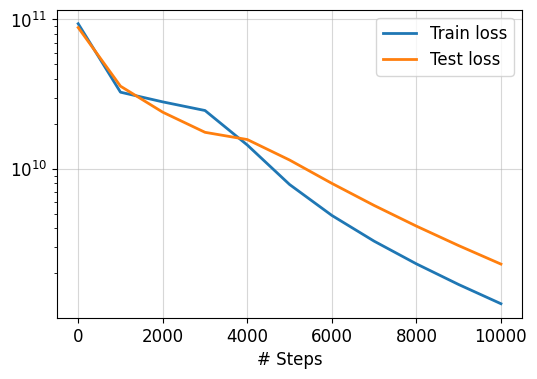

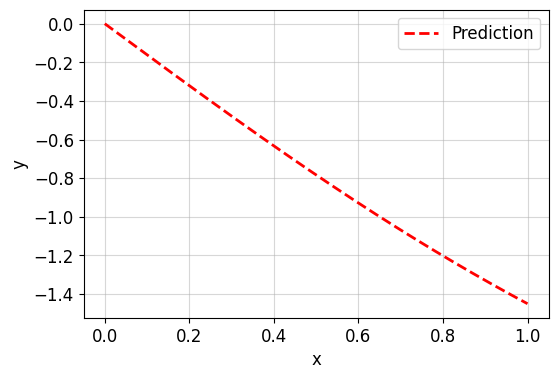

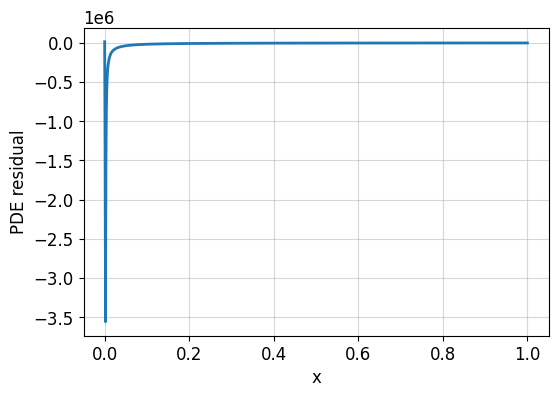

In [5]:
losshistory, train_state = model.train(iterations=10000)


dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot PDE residual
x = geom.uniform_points(1000, True)
y = model.predict(x, operator=pde)
plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("PDE residual")
plt.show()